In [62]:
import numpy as np
import librosa
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=160, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<int(1.3*sr):
    wav=np.pad(wav,int(np.ceil((1.3*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:int(1.3*sr)]
  spec=librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db


In [63]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [64]:
import matplotlib.pyplot as plt

In [65]:
from keras.utils import load_img, img_to_array

# 이미지 shape, array, 사진 확인하기
def showimg(imgarr):
    plt.imshow(imgarr, vmin=0, vmax=255)
    plt.axis('off')
    plt.show()
    print(imgarr.shape)

In [66]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/augmented_data/unstructured_data/train/caterwaul'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
caterwaul_path = train_path


In [67]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/augmented_data/unstructured_data/train/meow'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
meow_path = train_path


In [82]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/augmented_data/unstructured_data/val/caterwaul'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
caterwaul_val_path = train_path

In [83]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/augmented_data/unstructured_data/val/meow'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
meow_val_path = train_path

In [68]:
print(caterwaul_path[0])

/catclass_ai/augmented_data/unstructured_data/train/caterwaul/516_186_7.wav


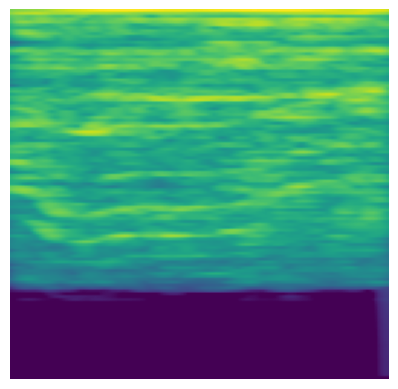

(128, 131)


In [72]:
showimg(spec_to_image(get_melspectrogram_db(str(caterwaul_path[4]))))

In [80]:
from PIL import Image

for i in range(len(caterwaul_path)):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(str(caterwaul_path[i]))))
    im.save("/catclass_ai/img_data/train/caterwaul/"+str(caterwaul_path[i]).split("/")[-1].split(".")[0]+'.jpeg')

In [81]:
from PIL import Image

for i in range(len(meow_path)):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(str(meow_path[i]))))
    im.save("/catclass_ai/img_data/train/meow/"+str(meow_path[i]).split("/")[-1].split(".")[0]+'.jpeg')

In [84]:
from PIL import Image

for i in range(len(caterwaul_val_path)):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(str(caterwaul_val_path[i]))))
    im.save("/catclass_ai/img_data/val/caterwaul/"+str(caterwaul_val_path[i]).split("/")[-1].split(".")[0]+'.jpeg')

In [85]:
from PIL import Image

for i in range(len(meow_val_path)):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(str(meow_val_path[i]))))
    im.save("/catclass_ai/img_data/val/meow/"+str(meow_val_path[i]).split("/")[-1].split(".")[0]+'.jpeg')

In [31]:
from keras.preprocessing.image import ImageDataGenerator

In [87]:
train = ImageDataGenerator(rescale=1/255)
train_dataset = train.flow_from_directory("/catclass_ai/img_data/train/",
                                          target_size=(128,131),
                                          batch_size = 32,
                                          class_mode = 'binary')

Found 22695 images belonging to 2 classes.


In [88]:
# 테스트 데이터 생성하기
test = ImageDataGenerator(rescale=1/255)

test_dataset = test.flow_from_directory("/catclass_ai/img_data/val/",
                                          target_size=(128,131),
                                          batch_size =32,
                                          class_mode = 'binary')

Found 333 images belonging to 2 classes.


In [89]:
train_dataset.class_indices

{'caterwaul': 0, 'meow': 1}

1.0


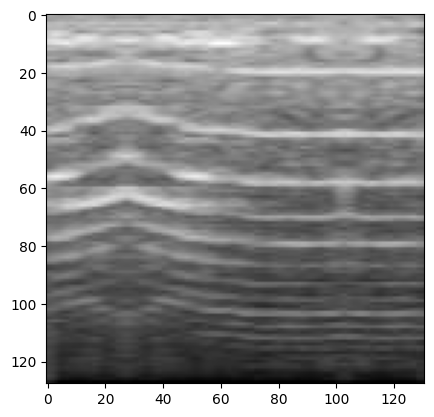

1.0


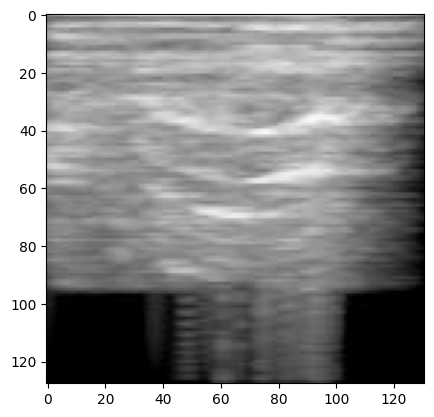

0.0


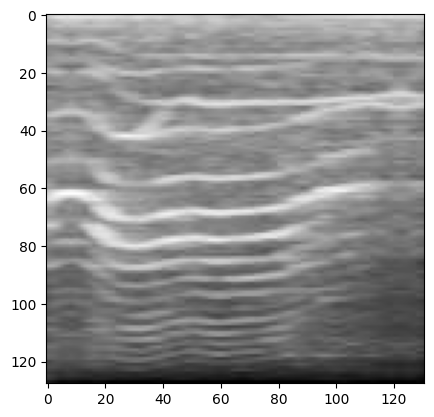

1.0


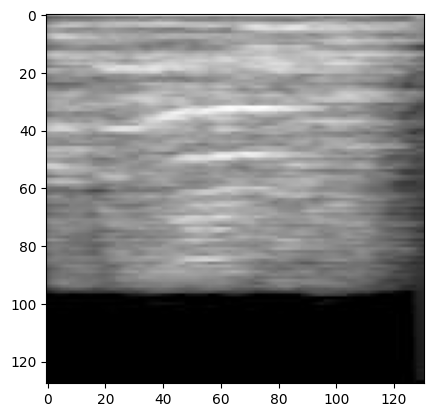

1.0


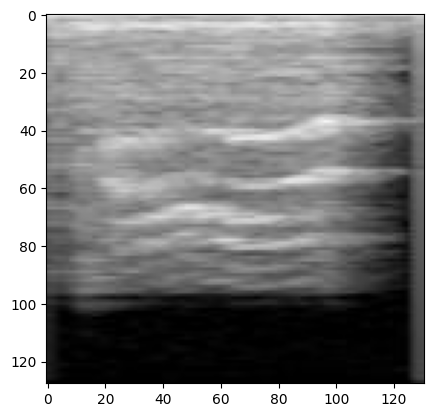

In [90]:
# 학습 데이터 레이블과 이미지 확인하기
for _ in range(5):
    img, label = train_dataset.next()
    print(label[0])
    plt.imshow(img[0])
    plt.show()

In [91]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Conv2D, MaxPool2D, Flatten, Dense
import random

In [97]:
model = Sequential()
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(128,131,3)))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(128,131,3)))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(128,131,3)))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

In [98]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 129, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 64, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 63, 64, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 62, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 31, 64)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 30, 31, 64)       

In [99]:
model.compile(optimizer = "adam" ,
              loss = "binary_crossentropy",
              metrics=["accuracy"])

In [100]:
from keras.callbacks import EarlyStopping

custom_early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=5
)

In [101]:
# 모델 학습
history =  model.fit(train_dataset,
                     epochs=100,
                     verbose=1,
                     validation_data = test_dataset,
                     callbacks=[custom_early_stopping])

Epoch 1/100


2023-11-23 20:57:50.701225: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f08f3503e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-23 20:57:50.701270: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2023-11-23 20:57:50.706873: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1700740670.794064    3659 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


710/710 [==============================] - 20s 23ms/step - loss: 0.1768 - accuracy: 0.9290 - val_loss: 0.0860 - val_accuracy: 0.9850
Epoch 2/100
710/710 [==============================] - 14s 20ms/step - loss: 0.0768 - accuracy: 0.9805 - val_loss: 0.0678 - val_accuracy: 0.9850
Epoch 3/100
710/710 [==============================] - 14s 20ms/step - loss: 0.0719 - accuracy: 0.9812 - val_loss: 0.0664 - val_accuracy: 0.9850
Epoch 4/100
710/710 [==============================] - 14s 20ms/step - loss: 0.0672 - accuracy: 0.9809 - val_loss: 0.0619 - val_accuracy: 0.9850
Epoch 5/100
710/710 [==============================] - 14s 19ms/step - loss: 0.0675 - accuracy: 0.9814 - val_loss: 0.0848 - val_accuracy: 0.9850
Epoch 6/100
598/710 [========================>.....] - ETA: 2s - loss: 0.0621 - accuracy: 0.9818

KeyboardInterrupt: 